In [18]:
from darts import TimeSeries
from src.data.util_tools import *
from src.config import *
from darts.dataprocessing.transformers import BoxCox
from darts.utils.statistics import check_seasonality, plot_acf, plot_pacf, stationarity_tests
from darts.utils.utils import ModelMode
from darts.dataprocessing.transformers import Diff
from darts.models import (
    ExponentialSmoothing,
    NaiveSeasonal,
    ARIMA,
    LinearRegressionModel,
    XGBModel
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Read df
df = pd.read_parquet("../data/interim/df_resampled.parquet") # Is resampled and stationary according to last week!
df.info

<bound method DataFrame.info of                        sensor_2
timestamp                      
2024-01-18 16:20:00  464.474747
2024-01-18 16:22:00  466.113889
2024-01-18 16:24:00  467.575000
2024-01-18 16:26:00  468.000000
2024-01-18 16:28:00  467.944444
...                         ...
2024-05-01 10:52:00  409.000000
2024-05-01 10:54:00  409.000000
2024-05-01 10:56:00  409.000000
2024-05-01 10:58:00  409.000000
2024-05-01 11:00:00  409.000000

[74721 rows x 1 columns]>

# Re-Check Stationarity:
Lets transform the data because according to darts our series isn't stationary.

In [3]:
# Create a timeseries object
series = TimeSeries.from_dataframe(df, value_cols=['sensor_2'])
series

<TimeSeries (DataArray) (timestamp: 74721, component: 1, sample: 1)> Size: 598kB
array([[[464.47474747]],

       [[466.11388889]],

       [[467.575     ]],

       ...,

       [[409.        ]],

       [[409.        ]],

       [[409.        ]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 598kB 2024-01-18T16:20:00 ... 2024-...
  * component  (component) object 8B 'sensor_2'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [24]:
# Make a train test split
train, val = series.split_before(0.98) #98% as train and 2% as validation

AttributeError: 'TimeSeries' object has no attribute 'before_time'

In [5]:
# Apply Box-Cox transformation to stabilize variance
transformer = BoxCox()
series_transformed = transformer.fit_transform(series)
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)

# Optionally, difference the series to remove trends
diff_transformer = Diff(lags=1, dropna=True)
series_transformed = diff_transformer.fit_transform(series_transformed)
train_transformed = diff_transformer.fit_transform(train_transformed)
val_transformed = diff_transformer.fit_transform(val_transformed)

In [11]:
adf_result = stationarity_tests(series) # After differencing the ts is stationary! 
# Very different from what my last result have proven me in the last weeks effort.
seasonality = check_seasonality(series)
print("Is the series stationary?:", adf_result)
print("Do we have a seasonailty?:", seasonality) 

/home/pindalu/FS2024/DSIOT/smartbuilding-Patrickliuu/.venv/lib/python3.10/site-packages/darts/utils/statistics.py:466: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


Is the series stationary?: False
Do we have a seasonailty?: (False, 0)


In [75]:
# Incl. ADF and KPSS in one function, what a blaze!
adf_result = stationarity_tests(series_transformed) # After differencing the ts is stationary! 
# Very different from what my last result have proven me in the last weeks effort.
seasonality = check_seasonality(series_transformed)
print("Is the series stationary?:", adf_result)
print("Do we have a seasonailty?:", seasonality) # Ohlala what a surprise, it gives me even a seasonality?

/home/pindalu/FS2024/DSIOT/smartbuilding-Patrickliuu/.venv/lib/python3.10/site-packages/darts/utils/statistics.py:466: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


Is the series stationary?: True
Do we have a seasonailty?: (True, 6)


## Lets start simple with the Naive Approaches.

In [152]:
from darts.models import NaiveMovingAverage
model = NaiveMovingAverage(720)
model.fit(train_transformed)

NaiveMovingAverage(input_chunk_length=720)

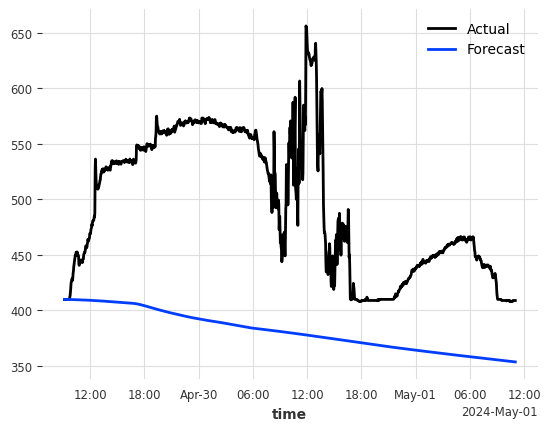

In [153]:
prediction_mean = model.predict(len(val))
prediction_mean = diff_transformer.inverse_transform(prediction_mean[1:])
prediction_mean = transformer.inverse_transform(prediction_mean)

val.plot(label='Actual')
prediction_mean.plot(label='Forecast')
plt.legend()
plt.show()

Let's see if the detected seasonality is worth anything.  
NaiveSeasonal:  

        This model always predicts the value of `K` time steps ago.
        When `K=1`, this model predicts the last value of the training set.
        When `K>1`, it repeats the last `K` values of the training set.


<Axes: xlabel='time'>

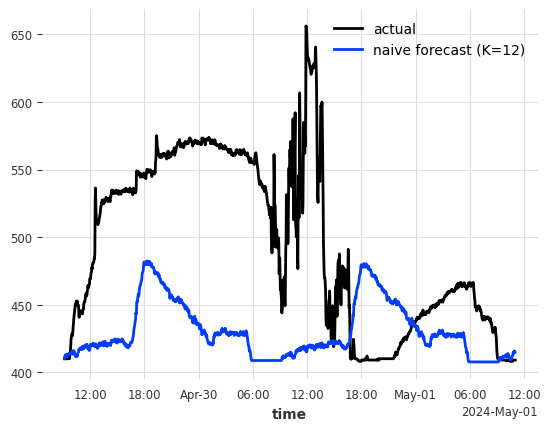

In [26]:
seasonal_model = NaiveSeasonal(K=720)
seasonal_model.fit(train_transformed)

# Prediciton
seasonal_forecast = seasonal_model.predict(len(val_transformed))

# Backtransformation
back_diff = diff_transformer.inverse_transform(seasonal_forecast[1:]) # Back transformation makes troubles. 
back_cox = transformer.inverse_transform(back_diff)

val.plot(label="actual")
back_cox.plot(label="naive forecast (K=12)")

**Change IDE Appearance to light, to see the confint of the plots**

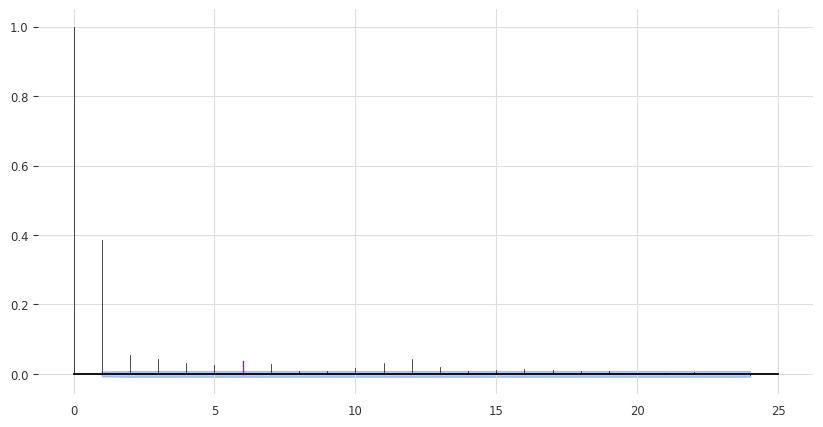

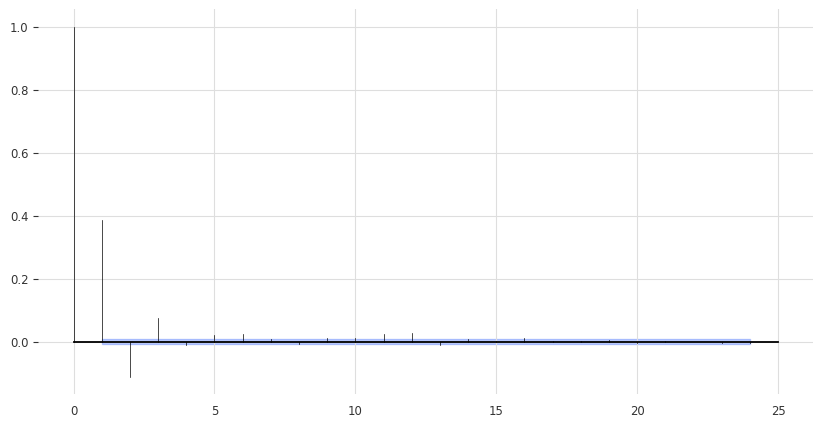

In [154]:
plot_acf(series_transformed, m=6, alpha=0.05)  # visualize autocorrelation
plot_pacf(series_transformed)  # visualize partial autocorrelations

## Exponential Smoother:
        This is a wrapper around
        `statsmodels  Holt-Winters' Exponential Smoothing
        we refer to this link for the original and more complete documentation of the parameters.
[Statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html)


In [16]:
#Fit model
model = ExponentialSmoothing(seasonal_periods=720, trend = ModelMode.NONE, seasonal=ModelMode.ADDITIVE) # Data is daily but the problem we have only a snapshot  till May, the privided seasonality according to the s_check is 6, lets see what comes out.

model.fit(train_transformed)

# Make prediction
prediction = model.predict(len(val_transformed)) # Half a day
# Invert differencing
prediction = diff_transformer.inverse_transform(prediction[1:])
# Invert Box-Cox transformation
prediction = transformer.inverse_transform(prediction)

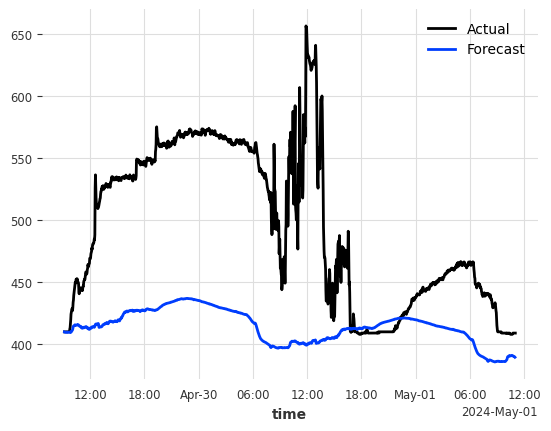

In [17]:
# Plot
val.plot(label='Actual')
prediction.plot(label='Forecast')
plt.legend()
plt.show()

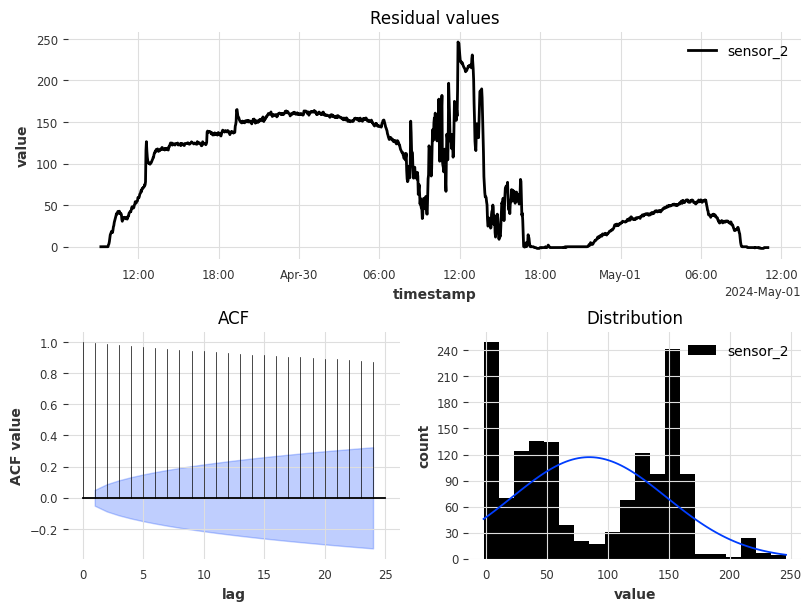

In [136]:
from darts.utils.statistics import plot_residuals_analysis

# Assuming you have a fitted model and the validation data
residuals = val[1:] - prediction
plot_residuals_analysis(residuals)

Looks like the Exponential-Smoother cannot capture the data at all. Lets go on and try it with an ARIMA


# Statistical Approach with sARiMA

In [7]:
# Lets try to fit a sARIMA
model = ARIMA(p=2, d=0, q=1, seasonal_order=(0,0,1,12), trend="ct") 
# According to the acf and pacf above differencing is necessary as i train it on the untransformed data! with 720 arima never converges..

In [8]:
model.fit(train_transformed)

/home/pindalu/FS2024/DSIOT/smartbuilding-Patrickliuu/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(p=2, d=0, q=1, seasonal_order=(0, 0, 1, 12), trend=ct, random_state=None, add_encoders=None)

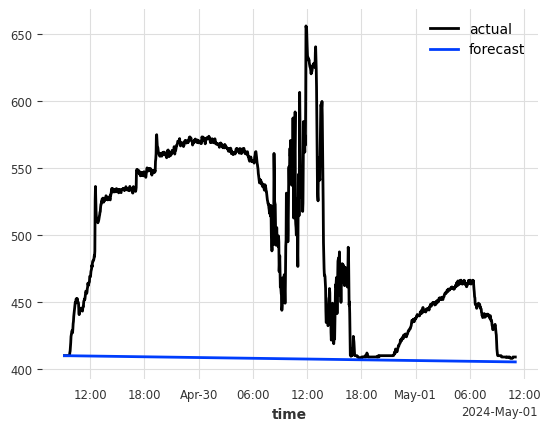

In [9]:
prediction = model.predict(len(val))
prediction = diff_transformer.inverse_transform(prediction[1:])
prediction = transformer.inverse_transform(prediction)

val.plot(label='actual')
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)  # Show confidence intervals
plt.legend()
plt.show()

AttributeError: 'numpy.float32' object has no attribute 'plot'

<Axes: xlabel='timestamp'>

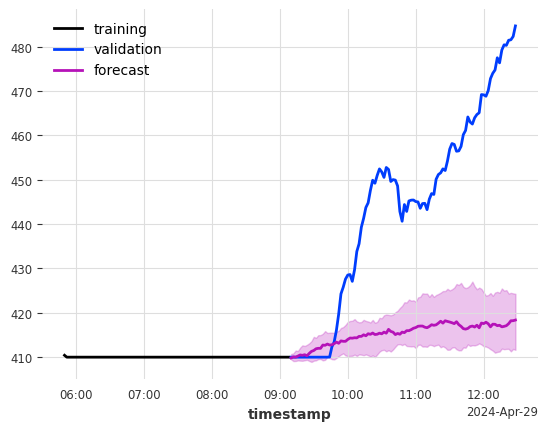

In [81]:
model = LinearRegressionModel(lags = 12, likelihood="quantile", quantiles=[0.05, 0.5, 0.95])
model.fit(train)
pred = model.predict(100, num_samples= 12)

train[-100:].plot(label="training")
val[:100].plot(label="validation")
pred.plot(label="forecast")

### A very short period into the future works quite well with the linear Regression model

sensor_2_q0.05 : 410.0
sensor_2_q0.50 : 410.0
sensor_2_q0.95 : 410.0


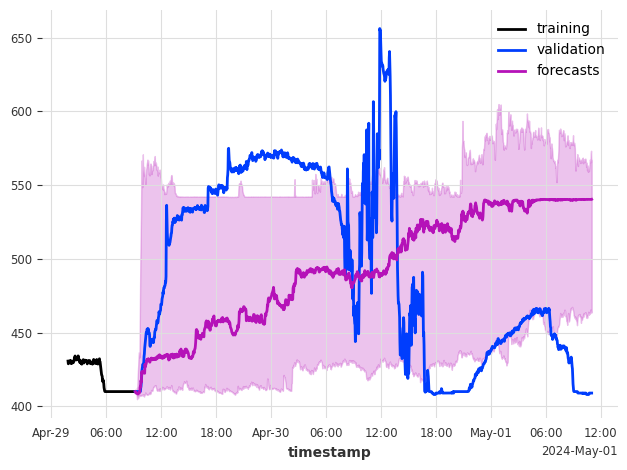

In [79]:
model = XGBModel(
    lags=6, likelihood="quantile", quantiles=[0.05, 0.5, 0.95] # To make it probabilistic instead of deterministic
)

model.fit(train)

pred_samples = model.predict(n=len(val), num_samples=24)
pred_params = model.predict(n=1, num_samples=1, predict_likelihood_parameters=True)

for vali, comp in zip(pred_params.values()[0], pred_params.components):
    print(f"{comp} : {round(vali, 3)}")

train[-220:].plot(label="training")
val.plot(label="validation")
pred_samples.plot(label="forecasts")
plt.tight_layout()


In [63]:
val

<TimeSeries (DataArray) (timestamp: 1496, component: 1, sample: 1)> Size: 12kB
array([[[410.]],

       [[410.]],

       [[410.]],

       ...,

       [[409.]],

       [[409.]],

       [[409.]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 12kB 2024-04-29T09:10:00 ... 2024-0...
  * component  (component) object 8B 'sensor_2'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None